# Exercise 05: t-SNE and DBSCAN

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Import data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN. 

We import the original 3-dimensional data and the data obtained by introducing [1, 2, 3, 4] additional dimensions with noisy input, rotated with an orthonormal random matrix. 

In [2]:
#fname,fnamey="x_def_3d.dat","y_def_3d.dat"

L_list = [3, 4, 5, 6, 7, 8, 9]

data_x = {}
data_y = {}

for dim in L_list:
    fname,fnamey=f"x_{dim}d.dat", f"y_{dim}d.dat"
    data_x[dim] = np.loadtxt("DATA/"+fname, delimiter='\t')
    data_y[dim] = np.loadtxt("DATA/"+fnamey,dtype=int)
    N=data_x[dim].shape[0]
    D=data_x[dim].shape[1]
    print("N=",N,"\tD=", D)


N= 1000 	D= 3
N= 1000 	D= 4
N= 1000 	D= 5
N= 1000 	D= 6
N= 1000 	D= 7
N= 1000 	D= 8
N= 1000 	D= 9


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps". We find it for each value of L.

In [3]:
## OLD METHOD

# def dist(x,i,j):
#     return np.linalg.norm(x[i]-x[j])
# 
# # print(dist(x,13,1))
# 
# mdist = np.zeros(N)
# for i in range(N):
#     dm = 1e100
#     for j in range(N):
#         if i!=j:
#             dij = dist(x,i,j);
#             if dij<dm:
#                 dm = dij
#     mdist[i] = dm
# mean_min_dist = mdist.mean()
# print("mean minimum distance between points: %.5f" %mean_min_dist)

For each point, we compute the distance from all the other points and consider the minimum value. Then we mediate this value over all points. 

In [4]:
from scipy import spatial

mean_min_dist = {}
for dim in L_list:
    x = data_x[dim]
    dist = spatial.distance_matrix(x, x)
    np.fill_diagonal(dist, np.inf)
    mean_min_dist[dim] = dist.min(axis=0).mean()
    print(f"{dim}D -> mean minimum distance between points: %.5f" %mean_min_dist[dim])

print("\nMean of the mean_min_dist: %.5f" %(np.array(list(dict.values(mean_min_dist))).mean()))

3D -> mean minimum distance between points: 18.55758
4D -> mean minimum distance between points: 21.76781
5D -> mean minimum distance between points: 25.10928
6D -> mean minimum distance between points: 28.45960
7D -> mean minimum distance between points: 31.19112
8D -> mean minimum distance between points: 33.67330
9D -> mean minimum distance between points: 35.86150

Mean of the mean_min_dist: 27.80289


Obviously, as the dimensionality of the space increases, the average distance between the points also increases. This is due to the fact that we intruduce L-3 dimensions by adding noisy inputs. 

## 1. The role of dimensions
### t-SNE visualization, for true labels

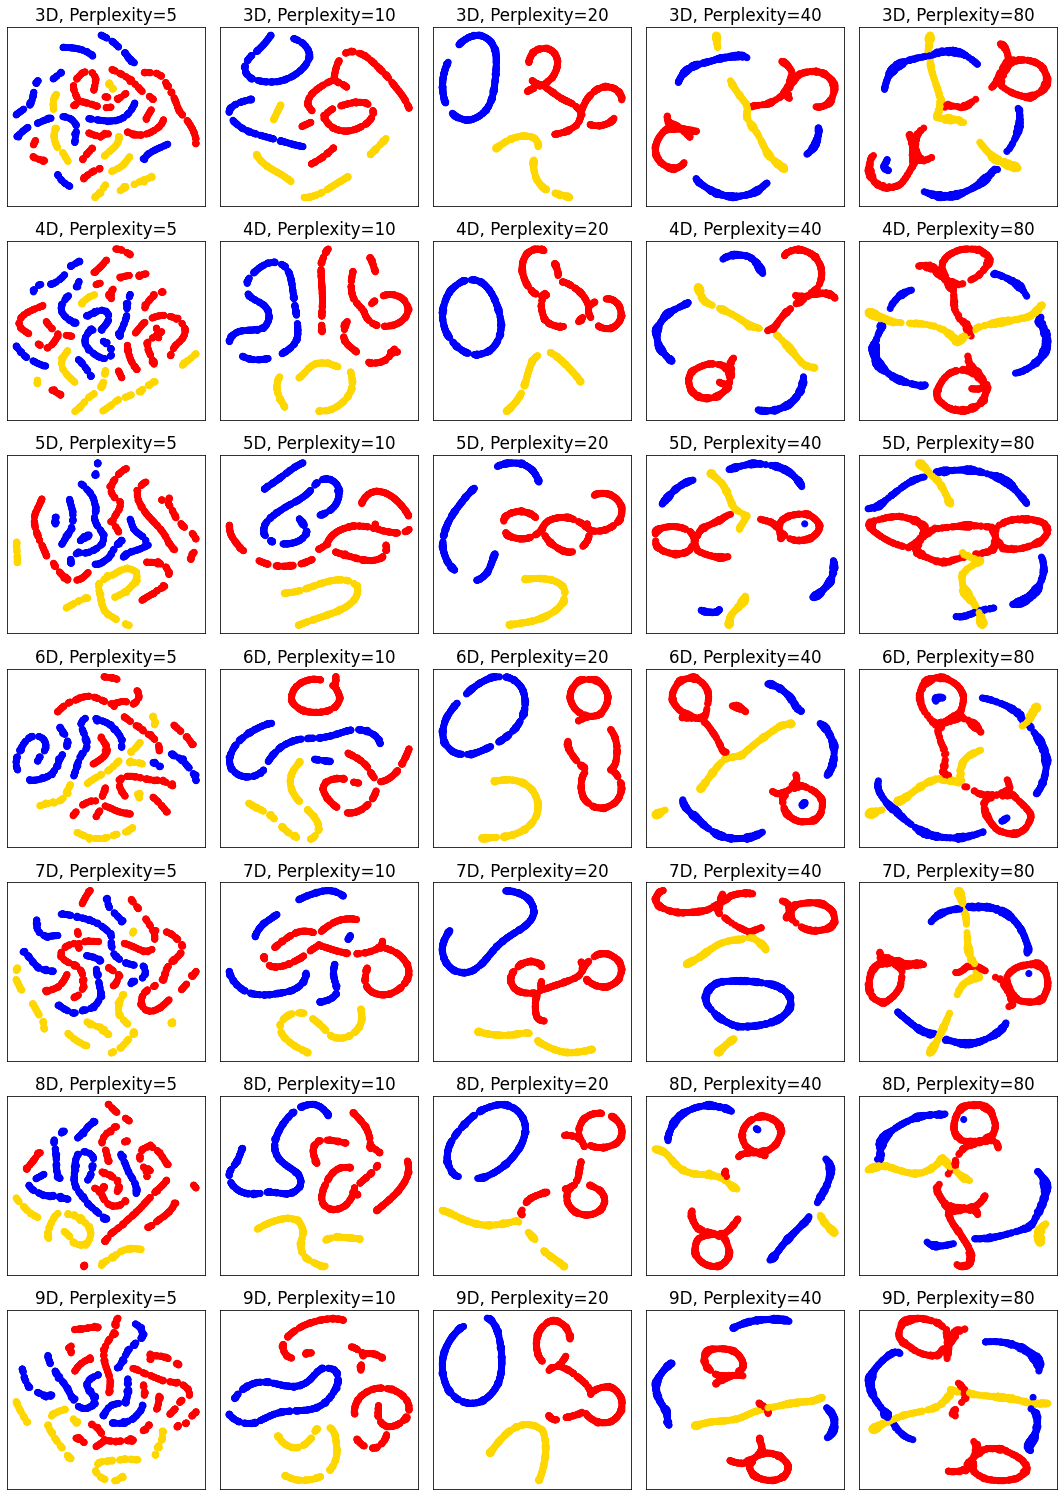

In [5]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
Ndim = len(L_list)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(Ndim, Np, figsize=(3*Np, 3*Np*Ndim/5))

X_all = [[] for _ in range(Ndim)]
for j, dim in enumerate(L_list):
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity,
                             learning_rate='auto')
        Y = tsne.fit_transform(data_x[dim])

        ax.set_title(f"{dim}D, Perplexity={perplexity}")
        ax.scatter(Y[:, 0], Y[:, 1], c=data_y[dim],cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all[j].append(Y)

fig.tight_layout()
plt.show()

### DBSCAN: find labels by applying clustering

We apply clustering to the original data, and then we apply t-SNE to visualize them in the 2D space. 

In [6]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6 # marker size

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both 
        clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)
        

It is true that DBSCAN has few parameters, but testing all combinations of parameters for each input dimension would be overly demanding from a computational point of view.
As a first step, let's see what happens in the base case, with 3 dimensions.

In [7]:
# examine X_all
X_all = np.array(X_all)
print(X_all.shape)

(7, 5, 1000, 2)


X_all has 7 rows corresponding to the input dimensions and 5 columns, one for each perplexity. Each element is a 1000x2 matrix.

3D case
Perplexity=20


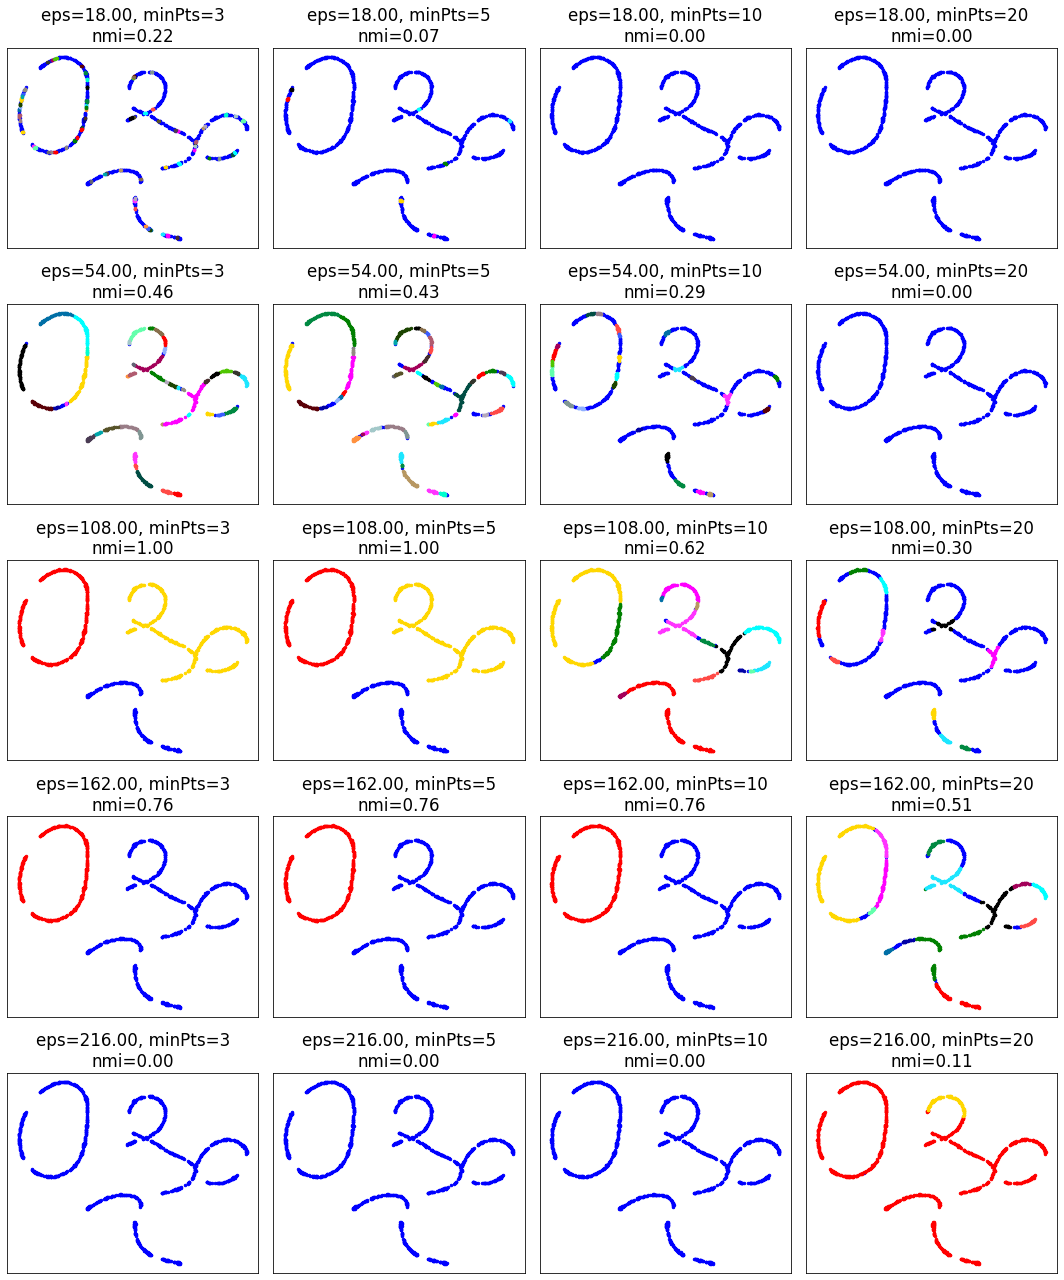

In [8]:

np.random.seed(12345)

dim = 3 # dimension considered
print(f"{dim}D case")

visual = 3
print(f"Perplexity={perplexities[visual-1]}")

# select data
X2D = X_all[dim-3,visual-1] # the 3rd is the best visualization above of 3D data
X = data_x[dim]
y_true = data_y[dim]

# esp range
r = int(mean_min_dist[dim])
eps_range = [r,3*r,6*r,9*r,12*r]

# min points range
min_sample_range = [3,5,10,20]

# grid search
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        # DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_

        # NMI
        nmi=NMI(y_hat, y_true)

        # PLOTTING
        plotting_ax(X2D,y_hat,ax[i,j])
        ax[i,j].tick_params(left=False,bottom=False)
        ax[i,j].xaxis.set_major_formatter(NullFormatter())
        ax[i,j].yaxis.set_major_formatter(NullFormatter())
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))

plt.tight_layout()
plt.show()


Next, let's consider the 3 best architectures and see how they behave when we consider data with additional dimensions.

Perplexity=20


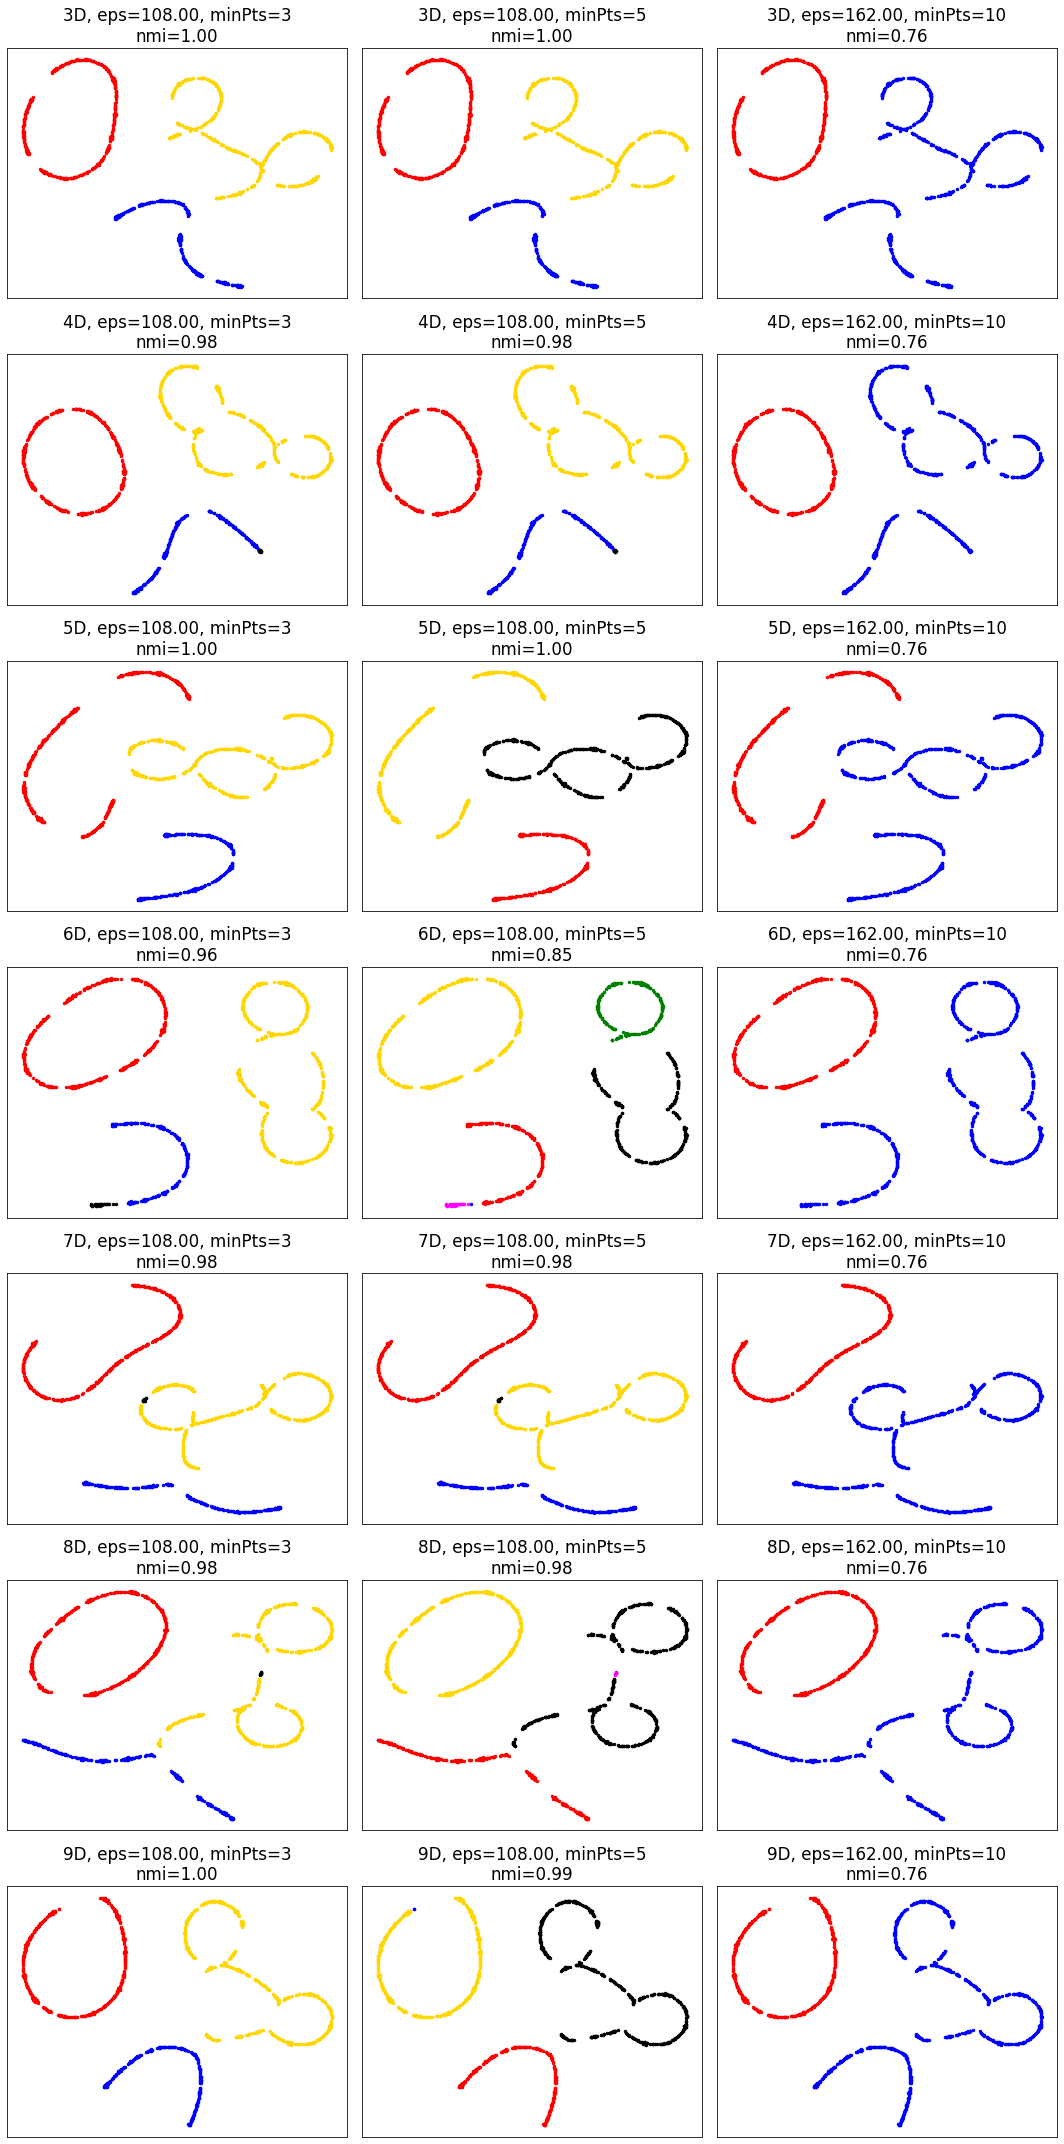

In [9]:
architectures = [[108, 3], [108, 5], [162, 10]]  #[eps, minPts]

visual = 3
print(f"Perplexity={perplexities[visual-1]}")

# esp range
r = int(mean_min_dist[dim])
eps_range = [r,3*r,6*r,9*r,12*r]

# min points range
min_sample_range = [3,5,10,20]

fig, ax = plt.subplots(Ndim, len(architectures), figsize=(15,30))

for i, dim in enumerate(L_list):
    # SELECT DATA
    X2D = X_all[dim-3,visual-1] # the 3rd is the best visualization above of 3D data
    X = data_x[dim]
    y_true = data_y[dim]

    for j, [eps, min_samples] in enumerate(architectures):
        
        # DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_

        # NMI
        nmi=NMI(y_hat, y_true)

        # PLOTTING
        plotting_ax(X2D,y_hat,ax[i,j])
        ax[i,j].tick_params(left=False,bottom=False)
        ax[i,j].xaxis.set_major_formatter(NullFormatter())
        ax[i,j].yaxis.set_major_formatter(NullFormatter())
        ax[i,j].set_title('%iD, eps=%.2f, minPts=%i\nnmi=%.2f'%(dim,eps,min_samples,nmi))

plt.tight_layout()
plt.show()


## 2. The role of “perplexity” in t-SNE

- **Provide your explanation on the patterns observed by varying the perplexity of t-SNE.** <br>
    ANSWEEEEER

- **Do the pattern vary if t-SNE is initialized by using principal component analysis (init=’pca’)?** <br>
    As we can see below, ...  ANSWEEEEER

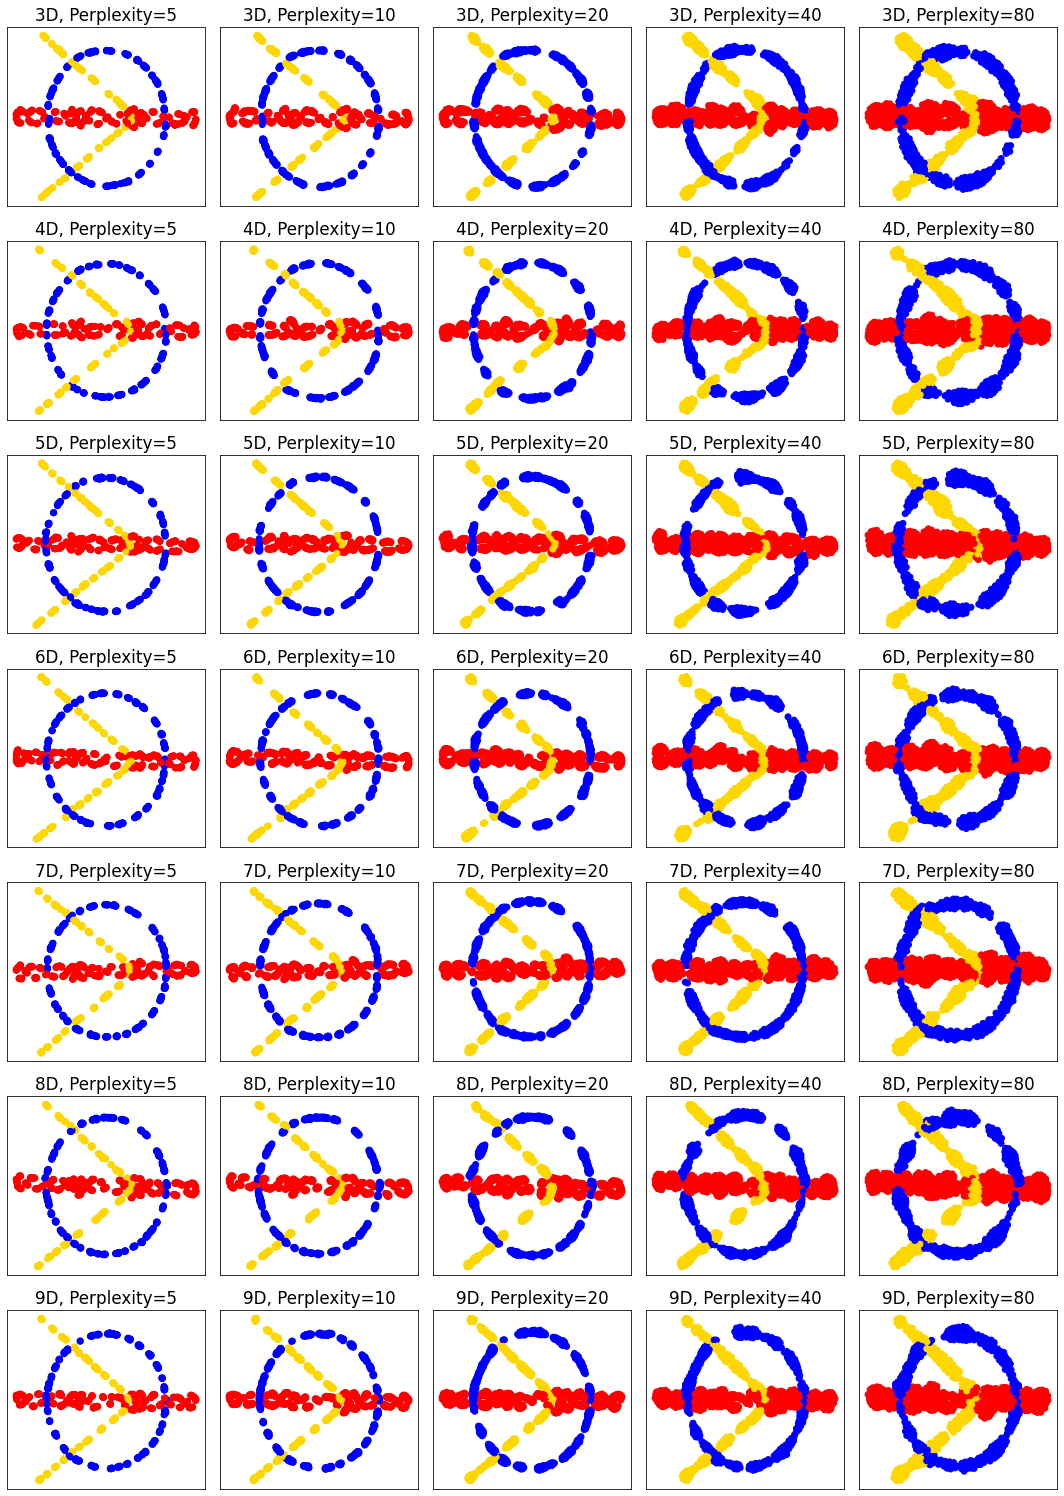

In [10]:
import warnings
warnings.filterwarnings("ignore")

(fig, subplots) = plt.subplots(Ndim, Np, figsize=(3*Np, 3*Np*Ndim/5))

X_all = [[] for _ in range(Ndim)]
for j, dim in enumerate(L_list):
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='pca',
                             random_state=0, perplexity=perplexity,
                             learning_rate='auto')
        Y = tsne.fit_transform(data_x[dim])

        ax.set_title(f"{dim}D, Perplexity={perplexity}")
        ax.scatter(Y[:, 0], Y[:, 1], c=data_y[dim],cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all[j].append(Y)

fig.tight_layout()
plt.show()

## 3. Tuning of “eps” and “minPts” in DBSCAN algorithm for clustering

**Task:** <br>
The grid with several values of “eps” and “minPts” shows that the normalized mutual information (NMI) between true and predicted clusters is varying. Is there a correlation between these two parameters in providing a high NMI? Is there a way of guessing good values for “eps” and “minPts”. <br>
Note: in the lesson we have looked at the typical distance between a point and its closest neighbor, but this does not say what is the typical distance from the 2nd, 3rd , …, “minPts”- neighbor. <br>
Furthermore, a possibility to consider is the [plotting of ranked distances](http://sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/).

## 4. VERY VERY OPTIONAL: t-SNE for clustering?

**Task:**
We know that t-SNE is stochastic and may converge to a different result if the random seed is varied. Moreover, visibly the result depends also on perplexity. Possibly, by checking which points are more likely to stay close to each other in different runs of t-SNE, one is able to assess the connectivity of the points in the original space, with implications for their clustering.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>